In [38]:
import csv
import copy
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

In [39]:
dataset = 'datasets/keypoint1000.csv'
model_save_path = 'models/keypoint_classifier.hdf5'
tflite_save_path = 'models/keypoint_classifier.tflite'

# Set number of classes

In [40]:
NUM_CLASSES = 12

# Dataset reading

In [41]:
def pre_process_dataset(X_dataset):
    # Reshape to 3D
    num_points = 21
    reshaped_dataset = X_dataset.reshape(-1, num_points, 3)

    # Shift coordinates
    for i in range(len(reshaped_dataset)):
        base_point = reshaped_dataset[i, 0]  # ID:0
        for j in range(num_points):
            reshaped_dataset[i, j] -= base_point

    # Flatten
    flattened_dataset = reshaped_dataset.reshape(-1, num_points * 3)

    # Normalization
    max_abs_value = np.max(np.abs(flattened_dataset))
    normalized_dataset = flattened_dataset / max_abs_value

    return normalized_dataset

In [42]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 3) + 1)))

In [43]:
X_dataset_preprocessed = pre_process_dataset(X_dataset)

In [44]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset_preprocessed, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [46]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 3, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),  # Increased units
    tf.keras.layers.BatchNormalization(),  # Added Batch Normalization
    tf.keras.layers.Dropout(0.3),  # Adjusted dropout rate
    tf.keras.layers.Dense(64, activation='relu'),  # Increased units
    tf.keras.layers.BatchNormalization(),  # Added Batch Normalization
    tf.keras.layers.Dense(32, activation='relu'),  # Increased units
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [47]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_2 (Dropout)         (None, 63)                0         
                                                                 
 dense_4 (Dense)             (None, 128)               8192      
                                                                 
 batch_normalization_2 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_3 (Batc  (None, 64)               256       
 hNormalization)                                      

In [48]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=50, verbose=1)

In [49]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [50]:
es_callback

In [51]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000


66/71 [==========================>...] - ETA: 0s - loss: 2.6381 - accuracy: 0.1123
Epoch 1: saving model to models\keypoint_classifier.hdf5
71/71 [==============================] - 1s 7ms/step - loss: 2.6257 - accuracy: 0.1140 - val_loss: 2.4587 - val_accuracy: 0.1017
Epoch 2/1000
62/71 [=========================>....] - ETA: 0s - loss: 2.4105 - accuracy: 0.1537
Epoch 2: saving model to models\keypoint_classifier.hdf5
71/71 [==============================] - 0s 4ms/step - loss: 2.4072 - accuracy: 0.1547 - val_loss: 2.3859 - val_accuracy: 0.1557
Epoch 3/1000
64/71 [==========================>...] - ETA: 0s - loss: 2.3220 - accuracy: 0.1759
Epoch 3: saving model to models\keypoint_classifier.hdf5
71/71 [==============================] - 0s 4ms/step - loss: 2.3197 - accuracy: 0.1774 - val_loss: 2.2708 - val_accuracy: 0.2580
Epoch 4/1000
57/71 [=======================>......] - ETA: 0s - loss: 2.2661 - accuracy: 0.2085
Epoch 4: saving model to models\keypoint_classifier.hdf5
71/71 [=======

In [52]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

24/24 [==============================] - 0s 1ms/step - loss: 0.3034 - accuracy: 0.8957


In [53]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [54]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 70ms/step
[2.21830804e-10 9.99771893e-01 2.64283678e-10 3.67526810e-13
 7.04120817e-10 8.38024789e-05 5.27778168e-12 1.30781264e-04
 3.62156150e-09 1.34035503e-07 1.35219525e-05 1.60444955e-08]
1


# Confusion matrix

94/94 [==============================] - 0s 823us/step


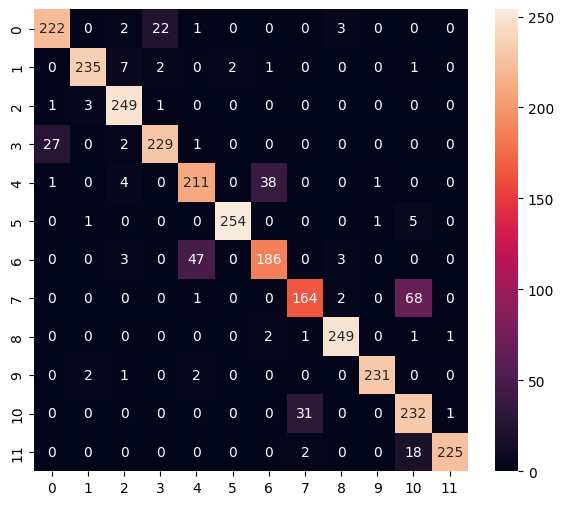

Classification Report
              precision    recall  f1-score   support

           0       0.88      0.89      0.89       250
           1       0.98      0.95      0.96       248
           2       0.93      0.98      0.95       254
           3       0.90      0.88      0.89       259
           4       0.80      0.83      0.81       255
           5       0.99      0.97      0.98       261
           6       0.82      0.78      0.80       239
           7       0.83      0.70      0.76       235
           8       0.97      0.98      0.97       254
           9       0.99      0.98      0.99       236
          10       0.71      0.88      0.79       264
          11       0.99      0.92      0.95       245

    accuracy                           0.90      3000
   macro avg       0.90      0.89      0.90      3000
weighted avg       0.90      0.90      0.90      3000



In [55]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [56]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [57]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\renyi\AppData\Local\Temp\tmpitptnrjx\assets


INFO:tensorflow:Assets written to: C:\Users\renyi\AppData\Local\Temp\tmpitptnrjx\assets


24072

# Inference test

In [58]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [59]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [60]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [61]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [62]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[6.73621159e-11 9.98831689e-01 3.13315519e-11 8.03154201e-14
 7.85874490e-11 5.10262442e-04 6.89108492e-13 5.51410660e-04
 1.19723129e-08 2.18565113e-08 1.06654305e-04 4.54191849e-08]
1
